#***Netflix Movie Recommendation***

###***Challenge Description***

*__Netflix__ is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: __CinematchSM__. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.*

*Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.*

*__Credits:__ https://www.netflixprize.com/rules.html*

*Netflix provided a lot of anonymous __rating data__, and a __prediction accuracy__ bar that is __10%__ better than what Cinematch can do on the same training data set. Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.*

###***Sources***
<ul>
<li> https://www.netflixprize.com/rules.html</li>
<li> https://www.kaggle.com/netflix-inc/netflix-prize-data</li>
<li> Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)</li>
<li>surprise library: http://surpriselib.com/ (we use many models from this library)</li>
<li>surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)</li>
<li>installing surprise: https://github.com/NicolasHug/Surprise#installation </li>
<li> Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)</li>
<li> SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c </li>
</ul>

###***Real World Business Objectives and Constraints***


***Objectives :***



1.   *Predict the rating that a user would give to a movie that he ahs not yet rated.*
2.   *Minimize the difference between predicted and actual rating i.e.RMSE and MAPE.*

***Constraints :***

1.   *Some form of interpretability.*

##***Machine Learning Problem Statement***

###***Data Overview***

*__Data Source :__*

*Get the data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data*

*__Data files :__*

*combined_data_1.txt*
*combined_data_2.txt*
*combined_data_3.txt*
*combined_data_4.txt*
*movie_titles.csv*
  
*The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following Sequence : CustomerID, Rating, Date*

*__Data Ranges :__*

*MovieIDs range from 1 to 17770 sequentially.*
*CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.*
*Ratings are on a five star (integral) scale from 1 to 5.*
*Dates have the format YYYY-MM-DD.*

##***Mapping the real world problem to a Machine Learning Problem***

*__Type of Machine Learning Problem :__*

*For a given movie and user we need to predict the rating would be given by the user to the movie. The given problem is a Recommendation problem. It can also seen as a Regression problem*

*__Performance metric :__*

*   *Mean Absolute Percentage Error*
*   *Root Mean Square Error*

*__Machine Learning Objective and Constraints :__*

*   *Minimize RMSE.*
*   *Try to provide some interpretability.*

In [1]:
#importing the relavant modules and functions
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
from prettytable import PrettyTable 

###***Exploratory Data Analysis***

In [ ]:
#loading the data set using drive function of google colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/My\ Drive/Colab Notebooks

In [5]:
#merging all the files of data into one single file
start     = datetime.now()
if not os.path.isfile('data.csv'):
    data  = open('data.csv', mode='w')
    row   = list()
    files = ['combined_data_1.txt','combined_data_2.txt','combined_data_3.txt','combined_data_4.txt']
    for file in files:
        print("Reading Ratings from {} is Ongoing".format(file))
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.001333


In [ ]:
#uploading the CSV file in Data Frame
print("Creating the DataFrame from data.csv file")
df = pd.read_csv('data.csv', sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')
print('Sorting the DataFrame by date')
df.sort_values(by='date', inplace=True)
print('Done.')

Creating the DataFrame from data.csv file
Done.

Sorting the DataFrame by date
Done.


In [ ]:
#publishing the top rows of DataFrame
df.head(6)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11
20393918,3870,510180,2,1999-11-11


In [ ]:
#publishing the descirption about the rating column
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
#just to make sure that all Nan containing rows are deleted.
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [ ]:
#removing the duplicate rows from the DataFrame
dup_bool = df.duplicated(['movie','user','rating'])
dups     = sum(dup_bool)
print("There are {} duplicate rating entries in the data.".format(dups))

There are 0 duplicate rating entries in the data.


In [ ]:
#undersatnding the Basic Statistics of Ratings, Users, and Movies
print("Total no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


###***Spliting data into Train and Test 80:20***

In [ ]:
#spliting the DataFrame and creating csv file accordingly
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)
print('File train.csv : created successfully')
if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)
print('File test.csv  : created successfully')

File train.csv : created successfully
File test.csv  : created successfully


In [ ]:
#creating DataFrame from train.csv and test.csv
train_df = pd.read_csv("train.csv", parse_dates=['date'])
print('DataFrame train_df : created successfully')
test_df  = pd.read_csv("test.csv")
print('DataFrame test_df  : created successfully')

DataFrame train_df : created successfully
DataFrame test_df  : created successfully


###***Basic Statistics in Train  and Test data : Ratings, Users, and Movies***

In [ ]:
print("Total no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


In [ ]:
print("Total no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


###***Exploratory Data Analysis on Train data***

In [ ]:
#function to make y-axis more readable
def human(num,units='M'):
    units = units.lower()
    num   = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [ ]:
#Distribution of ratings
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
#Add new column - week day to the data set for analysis
pd.options.mode.chained_assignment = None
train_df['day_of_week'] = train_df.date.dt.day_name()
train_df.tail(6)

,movie,user,rating,date,day_of_week
80384399,6902,157806,4,2005-08-08,Monday
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


In [ ]:
#Number of Ratings per a month
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [ ]:
#Analysis on the Ratings given by user
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head(6)

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
1314869     8964
Name: rating, dtype: int64

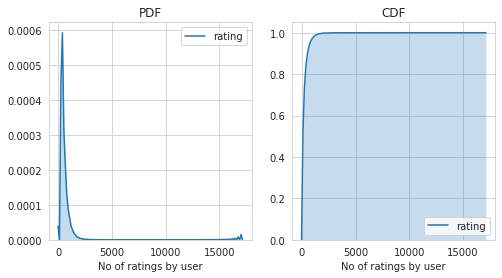

In [ ]:
#Plotting number of rating movies by user pdf and cdf
fig = plt.figure(figsize=plt.figaspect(.5))
ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title('PDF')
ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')
plt.show()

In [ ]:
#Understanding the statistical parameters of number of rated movies per user
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

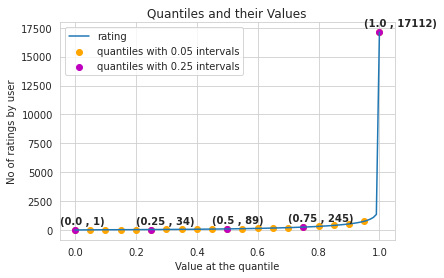

In [ ]:
#plotting data to understand the percentile wise distribution
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500),fontweight='bold')
plt.show()

In [ ]:
#quantile wise rated movies table
x = PrettyTable()
x.field_names = ['Percentile','Number of Rating']
for i,j in enumerate(quantiles[::5]):
  x.add_row([round(i*0.05,2)*10,j])
print(x)

+------------+------------------+
| Percentile | Number of Rating |
+------------+------------------+
|    0.0     |        1         |
|    0.5     |        7         |
|    1.0     |        15        |
|    1.5     |        21        |
|    2.0     |        27        |
|    2.5     |        34        |
|    3.0     |        41        |
|    3.5     |        50        |
|    4.0     |        60        |
|    4.5     |        73        |
|    5.0     |        89        |
|    5.5     |       109        |
|    6.0     |       133        |
|    6.5     |       163        |
|    7.0     |       199        |
|    7.5     |       245        |
|    8.0     |       307        |
|    8.5     |       392        |
|    9.0     |       520        |
|    9.5     |       749        |
|    10.0    |      17112       |
+------------+------------------+


<IPython.core.display.Javascript object>

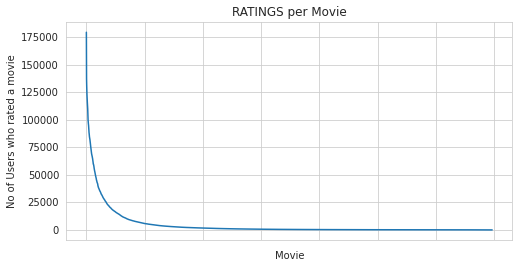

In [ ]:
#Analysis of ratings of a movie given by a user
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)
fig = plt.figure(figsize=plt.figaspect(.5))
ax  = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])
plt.show()

<IPython.core.display.Javascript object>

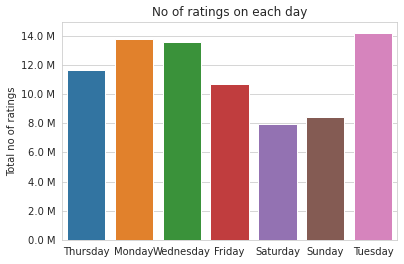

In [ ]:
#Number of ratings on each day of the week
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [ ]:
#understanding the mean rating of each day
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print("Average ratings day wise :")
print(avg_week_df)

Average ratings day wise :
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64


###***Creating sparse matrix from train and test data frame***

In [4]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in the Directory, getting it from disk")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("Loaded into variable : train_sparse_matrix")
else: 
    print("We are creating sparse_matrix from the dataframe")
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,train_df.movie.values)),)
    print('Shape of train_sparse_matrix (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for Loading it in future')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Saved in directory as train_sparse_matrix.npz')
print('Time taken in creation of matrix :',datetime.now() - start)

It is present in the Directory, getting it from disk
Loaded into variable : train_sparse_matrix
Time taken in creation of matrix : 0:00:07.994876


In [5]:
#understanding the non zero and zero values in the matrix through sparsity
us,mv = train_sparse_matrix.shape
elem  = train_sparse_matrix.count_nonzero()
print("Sparsity of Train matrix : {}%".format((1-(elem/(us*mv)))*100) )

Sparsity of Train matrix : 99.8292709259195%


In [6]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in the Directory, getting it from disk")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print('Loaded into variable : test_sparse_matrix')
else:
    print("We are creating sparse_matrix from the dataframe")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,test_df.movie.values)))
    print('Shape of train_sparse_matrix (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Saved in directory as train_sparse_matrix.npz')    
print('Time taken in creation of matrix :',datetime.now()-start)

It is present in the Directory, getting it from disk
Loaded into variable : test_sparse_matrix
Time taken in creation of matrix : 0:00:02.386973


In [7]:
#understanding the non zero and zero values in the matrix through sparsity
us,mv = test_sparse_matrix.shape
elem  = test_sparse_matrix.count_nonzero()
print("Sparsity of Test matrix : {}% ".format((1-(elem/(us*mv)))*100) )

Sparsity of Test matrix : 99.95731772988694% 


###***Finding Global average of all Movie ratings, Average rating per User, and Average rating per Movie***

In [ ]:
#defining fuction to calculate the average of movie rating, for each movie and for each user
def get_average_ratings(sparse_matrix, of_users):
    ax              = 1 if of_users else 0
    sum_of_ratings  = sparse_matrix.sum(axis=ax).A1
    is_rated        = sparse_matrix!=0
    no_of_ratings   = is_rated.sum(axis=ax).A1
    u,m             = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] !=0}
    return average_ratings

In [ ]:
#finding global average of all movie ratings
train_averages            = dict()
train_global_average      = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global']  = train_global_average
train_averages

{'global': 3.582890686321557}

In [ ]:
#finding average rating per user
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('Average rating of user 10 :',train_averages['user'][10])

Average rating of user 10 : 3.3781094527363185


In [ ]:
#finding average rating per movie
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('Average rating of movie 15 :',train_averages['movie'][15])

Average rating of movie 15 : 3.3038461538461537


<IPython.core.display.Javascript object>

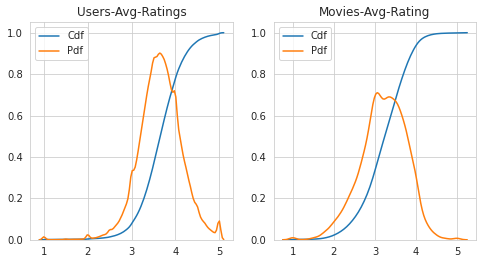

In [ ]:
#draw pdfs for average rating per user and average
start = datetime.now()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages,ax=ax1,hist=False,kde_kws=dict(cumulative=True),label='Cdf')
sns.distplot(user_averages,ax=ax1,hist=False,label='Pdf')
ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages,ax=ax2,hist=False,kde_kws=dict(cumulative=True),label='Cdf')
sns.distplot(movie_averages,ax=ax2,hist=False,label='Pdf')
plt.show()

###***Cold Start problem with User and Movie***

In [ ]:
#cold start problem with users
tr_tes_user_diff = len(set(np.unique(test_df.user.values))-set(np.unique(train_df.user.values)))
to_number_users  = len(set(np.unique(train_df.user.values)).union(set(np.unique(test_df.user.values))))
print('Number of new users in test data  :',tr_tes_user_diff)
print('Percent of new users in test data :',round((tr_tes_user_diff/to_number_users)*100,2),'%')

Number of new users in test data  : 75148
Percent of new users in test data : 15.65 %


In [ ]:
#cold start problem with users
tr_tes_movie_diff = len(set(np.unique(test_df.movie.values))-set(np.unique(train_df.movie.values)))
to_number_movie   = len(set(np.unique(train_df.movie.values)).union(set(np.unique(test_df.movie.values))))
print('Number of new movies in test data  :',tr_tes_movie_diff)
print('Percent of new movies in test data :',round((tr_tes_movie_diff/to_number_movie)*100,2),'%')

Number of new movies in test data  : 346
Percent of new movies in test data : 1.95 %


###***Computing Similarity matrices***

*Calculating User User Similarity_Matrix is not very easy unless you have huge Computing Power and lots of time because of number of users being lare. We have __405,041 users__ in our training data set and computing similarities between them with __17K dimensional vector__ will involve roughly __82 Billion__ calculations, which is time consuming.*

***Is there any other way to compute user user similarity?***

*An alternative is to compute similar users for a particular user, whenenver required i.e. Run time. We maintain a binary Vector for users, which tells us whether we already computed or not. If not : Compute top, let's just say, __1000 most similar users__ for this given user, and add this to our datastructure, so that we can just access it (similar users) without recomputing it again. If It is already Computed: Just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a __long time ago__. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). Which datastructure to use: - It is purely implementation dependant. One simple method is to maintain a __Dictionary Of Dictionaries__. __key : userid__  __value: Again a dictionary - key : Similar User - value: Similarity Value__*

In [ ]:
#calculating movie movie similarity
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("Creating the Movie Movie similarity Matrix")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Similarity Matrix created and stored in variable   : m_m_sim_sparse")
    print("Saving the Similarity Matrix created to directory  : m_m_sim_sparse.npz")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("File m_m_sim_sparse.npz created in directory       : Successfully")
    print("Dimension of the Matrix created m_m_sim_sparse is  :",m_m_sim_sparse.shape)

else:
    print("File name m_m_sim_sparse is already present in the directory")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Similarity matrix loaded and saved in the varibale : m_m_sim_sparse")
print("Dimension of the Matrix created m_m_sim_sparse is  :",m_m_sim_sparse.shape)
print('Time Taken in the creating/loading the matrix      :',datetime.now() - start)

File name m_m_sim_sparse is already present in the directory
Similarity matrix loaded and saved in the varibale : m_m_sim_sparse
Dimension of the Matrix created m_m_sim_sparse is  : (17771, 17771)
Time Taken in the creating/loading the matrix      : 0:00:51.817256


*Even though we have __similarity measure__ of each movie, with all other movies. We generally don't consider much about least similar movies.
Most of the times, only __top_xxx__ similar items matters. It may be __10__ or __100__. We take only those __top similar__ movie ratings and store them in a saperate __dictionary__*

In [ ]:
#getting an array of all the movie ids
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [ ]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print('Time taken in computing     :',datetime.now()-start)
print('Movie Id for similar movies :')
similar_movies[15][0:9]

Time taken in computing     : 0:00:30.937080
Movie Id for similar movies :


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590])

###***Finding most similar movies using similarity matrix***

In [ ]:
#First Let us load the movie details into a DataFrame.
movie_titles = pd.read_csv("movie_titles.csv",header=None,names=['movie_id','year_of_release','title'],index_col='movie_id',encoding="ISO-8859-1")
movie_titles[0:10]

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [ ]:
movie_titles[100:120]

,year_of_release,title
movie_id,,
101,1997.0,Complete Shamanic Princess
102,2004.0,Notre Musique
103,1976.0,Sanford and Son: Season 6
104,1965.0,The Great Race
105,2002.0,Obsessed
106,2004.0,Stevie Ray Vaughan and Double Trouble: Live at...
107,2000.0,Magnolia: Bonus Material
108,2004.0,Spartan
109,1996.0,No Way Back


In [ ]:
#working on a particular movie to test results
mv_id = 118
print("Title of the Movie   :",movie_titles.loc[mv_id].values[1])
print("Number of user rated :",format(train_sparse_matrix[:,mv_id].getnnz()))
print("We have {} movies which are similar to this and we will get only top most.".format(m_m_sim_sparse[:,mv_id].getnnz()))

Title of the Movie   : Rambo: First Blood Part II
Number of user rated : 15541
We have 17379 movies which are similar to this and we will get only top most.


In [ ]:
#preparing the similarity matrix and using it on the index
similarities    = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices     = similarities.argsort()[::-1][1:]

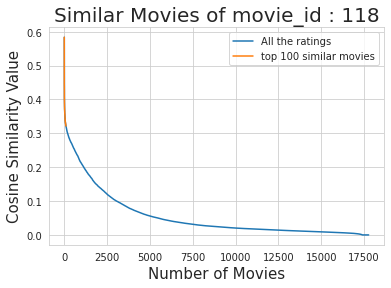

In [ ]:
#plotting graph of number of movies having similarity vs similarity value between movies
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of movie_id : {}".format(mv_id), fontsize=20)
plt.xlabel("Number of Movies", fontsize=15)
plt.ylabel("Cosine Similarity Value",fontsize=15)
plt.legend()
plt.show()

In [ ]:
#checking movies by names
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
16532,1982.0,Rambo: First Blood: Ultimate Edition
9614,1979.0,Rocky II
12263,1988.0,Rambo III: Ultimate Edition
9565,1982.0,Rocky III
3715,1985.0,Commando
13501,1985.0,Rocky IV
8107,1987.0,Predator: Collector's Edition
15956,1991.0,The Last Boy Scout
1799,1990.0,Die Hard 2: Die Harder


###***Building sample Train and Test***

In [ ]:
#function to create a sample sparse matrix from the bigger matrix of all the users and movies
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path,verbose=True):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users   = np.unique(row_ind)
    movies  = np.unique(col_ind)
    print("Original Matrix (users, movies) : ({} {})".format(len(users), len(movies)))
    print("Original Matrix (Ratings)       : ({})".format(len(ratings)))
    np.random.seed(15)
    sample_users         = np.random.choice(users, no_users, replace=False)
    sample_movies        = np.random.choice(movies, no_movies, replace=False)
    mask                 = np.logical_and(np.isin(row_ind, sample_users),np.isin(col_ind, sample_movies))
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),shape=(max(sample_users)+1, max(sample_movies)+1))
    if verbose:
        print("Sampled Matrix (users, movies)  : ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix (Ratings)        : ({})".format(ratings[mask].shape[0]))
    print('Saving it into directory for furthur usage.')
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Matrix Saved in Directory')
    return sample_sparse_matrix

In [ ]:
#using above defined function to create a sample train matrix
start = datetime.now()
path = "sample/small/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your directory, Uploading it.")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("Sparse Matrix ready on variable : sample_train_sparse_matrix")
else: 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,path = path)
print('Time taken in the process :',datetime.now() - start)

It is present in your directory, Uploading it.
Sparse Matrix ready on variable : sample_train_sparse_matrix
Time taken in the process : 0:00:00.964937


In [ ]:
#using above defined function to create a sample test matrix
start = datetime.now()
path  = "sample/small/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your directory, Uploading it.")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("Sparse Matrix ready on variable : sample_test_sparse_matrix")
else:
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,path = path)
print('Time taken in the process :',datetime.now() - start)

It is present in your directory, Uploading it.
Sparse Matrix ready on variable : sample_test_sparse_matrix
Time taken in the process : 0:00:00.376774


###***Finding Global Average of : all movie ratings, rating per User, and rating per Movie from Sampled Train***

In [ ]:
#get the global average of ratings in our train set.
sample_train_averages           = dict()
global_average                  = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

In [ ]:
#Finding Average rating per User
sample_train_averages['user']   = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('Average rating of user 1515220 :',sample_train_averages['user'][1179])

Average rating of user 1515220 : 3.6666666666666665


In [ ]:
#Finding Average rating per Movie
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][5317])


 AVerage rating of movie 15153 : 3.390205371248025


###***Featurizing data for regression problem***

In [ ]:
print('No of ratings in Our Sampled train matrix is : {}'.format(sample_train_sparse_matrix.count_nonzero()))
print('No of ratings in Our Sampled test  matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 129286
No of ratings in Our Sampled test  matrix is : 7333


In [ ]:
#get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [8]:
#preparing the final features for train
start = datetime.now()
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exist in the directory, uploading directly" )
else:
    print('Preparing {} tuples for the dataset.'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st                     = datetime.now()        
            user_sim               = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users          = user_sim.argsort()[::-1][1:]
            top_ratings            = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings  = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))        
            
            movie_sim              = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies         = movie_sim.argsort()[::-1][1:]
            top_ratings            = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for : {} rows in time : {}".format(count, datetime.now() - start))
print('Time taken : ',datetime.now() - start)

File already exist in the directory, uploading directly
Time taken :  0:00:00.486290


###***Features***

- __GAvg__ : Average rating of all the ratings 
- __Similar users rating of this movie__ : sur1, sur2, sur3, sur4, sur5 top 5 similar users who rated that movie.    
- __Similar movies rated by this user__ : smr1, smr2, smr3, smr4, smr5 top 5 similar movies rated by this movie. 
- __UAvg__ : User's Average rating
- __MAvg__ : Average rating of this movie
- __rating__ : Rating of this movie by this user.


In [9]:
#Reading from the file to make a Train_dataframe
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5
5,125275,33,3.581679,3.0,4.0,2.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,3.412698,4.092437,4


In [ ]:
#get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [10]:
#preparing the final features for test
start = datetime.now()
if os.path.isfile('sample/small/reg_test.csv'):
    print("File already exist in the directory, uploading directly" )
else:
    print('preparing {} tuples for the dataset.\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            try:
                user_sim               = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users          = user_sim.argsort()[::-1][1:]
                top_ratings            = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings  = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise
            try:
                movie_sim              = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies         = movie_sim.argsort()[::-1][1:]
                top_ratings            = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for : {} rows in time : {}".format(count, datetime.now() - start))
print('Time taken : ',datetime.now() - start)

File already exist in the directory, uploading directly
Time taken :  0:00:00.001123


In [11]:
#Reading from the file to make a Test_dataframe
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1
5,117617,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


In [ ]:
pip install scikit-surprise

In [13]:
from surprise import Reader, Dataset

*__Transforming Train Data :__*

*We can't give raw data : __movie__, __user__, __rating__ to train the model in __Surprise__ library. They have a seperate format for TRAIN and TEST data, which will be useful for training the models like __SVD__ in Surprise.
We can form the trainset from a file, or from a __Pandas DataFrame__.*

In [14]:
#It is to specify how to read the dataframe.
reader     = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset   = train_data.build_full_trainset()

In [15]:
#Transforming test data
testset    = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

##***Applying Machine Learning models***

*__Global dictionary__ that stores rmse and mape for all the models. It stores the metrics in a dictionary of dictionaries.*

- __keys__ : model names(string)

- __value__: dict(key : metric, value : value )


In [21]:
models_evaluation_train = dict()
models_evaluation_test  = dict()
models_evaluation_train, models_evaluation_test

({}, {})

In [16]:
#To get rmse and mape given actual and predicted ratings.
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred))]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [17]:
#defining function to train and test the model
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):    
    train_results = dict()
    test_results  = dict()
    print('Training the model.')
    start = datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Training : Done In time :'.format(datetime.now()-start))
    print('Evaluating the model with TRAIN data.')
    start = datetime.now()
    y_train_pred = algo.predict(x_train)
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    train_results = {'rmse': rmse_train,'mape' : mape_train,'predictions' : y_train_pred}
    print('Evaluating the model with Test data.')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    test_results = {'rmse': rmse_test,'mape' : mape_test,'predictions':y_test_pred}
    if verbose:
        print('TEST DATA RMSE : ', rmse_test)
        print('TEST DATA MAPE : ', mape_test)
    return train_results, test_results

In [18]:
#Utility functions for Surprise modes
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred   = np.array([pred.est for pred in predictions])    
    return actual, pred

def get_errors(predictions, print_them=False):
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)
    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True): 
    start = datetime.now()
    train = dict()
    test  = dict()
    st    = datetime.now()
    print('Training the model now')
    algo.fit(trainset)
    print('Done in time taken    : {} \n'.format(datetime.now()-st))
    st = datetime.now()
    print('Evaluating the model with Train data.')
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    if verbose:
        print('TRAIN DATA RMSE : ', train_rmse)
        print('TRAIN DATA MAPE : ', train_mape)
    if verbose:
        print('Adding train results in the dictionary.')
    train['rmse']         = train_rmse
    train['mape']         = train_mape
    train['predictions']  = train_pred_ratings
    
    st = datetime.now()
    print('Evaluating the model with Test data')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    if verbose:
        print('TEST DATA RMSE : ', test_rmse)
        print('TEST DATA MAPE : ', test_mape)
    if verbose:
        print('Adding the test results in test dictionary.')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    print('Total time taken to run this algorithm :', datetime.now() - start)
    return train, test

###***XGBoost with initial 13 features***

In [19]:
#importing xgboost and preparing the data set train and test
import xgboost as xgb
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']
x_test  = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test  = reg_test_df['rating']

In [22]:
#initialize Our first XGBoost model
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

#store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo']  = test_results

Training the model.
[03:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training : Done In time :
Evaluating the model with TRAIN data.
Evaluating the model with Test data.
TEST DATA RMSE :  1.076373581778953
TEST DATA MAPE :  34.48223172520999


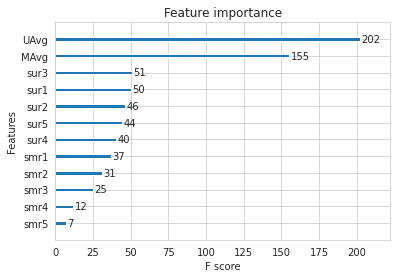

In [23]:
%matplotlib inline
xgb.plot_importance(first_xgb)
plt.show()

###***Suprise BaselineModel***

***Predicted_rating : baseline prediction*** 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

***Optimization function : Least Squares Problem***

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [24]:
#options are to specify, how to compute those user and item biases
from surprise import BaselineOnly 
bsl_options = {'method': 'sgd','learning_rate': .001}
bsl_algo    = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

Training the model now
Estimating biases using sgd...
Done in time taken    : 0:00:01.019636 

Evaluating the model with Train data.
time taken : 0:00:01.339522
TRAIN DATA RMSE :  0.9347153928678286
TRAIN DATA MAPE :  29.389572652358183
Adding train results in the dictionary.
Evaluating the model with Test data
time taken : 0:00:00.062304
TEST DATA RMSE :  1.0730330260516174
TEST DATA MAPE :  35.04995544572911
Adding the test results in test dictionary.
Total time taken to run this algorithm : 0:00:02.423396


In [25]:
#Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo']  = bsl_test_results

###***XGBoost with initial 13 features + Surprise Baseline predictor***

In [28]:
#adding our baseline_predicted value as our another feature.
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637
5,125275,33,3.581679,3.0,4.0,2.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,3.412698,4.092437,4,3.208080


In [29]:
#adding that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679
5,117617,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


In [30]:
#preparing train and test data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']
x_test  = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test  = reg_test_df['rating']

In [31]:
#Initialize Our first XGBoost model.
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

Training the model.
[03:59:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training : Done In time :
Evaluating the model with TRAIN data.
Evaluating the model with Test data.
TEST DATA RMSE :  1.0765603714651855
TEST DATA MAPE :  34.4648051883444


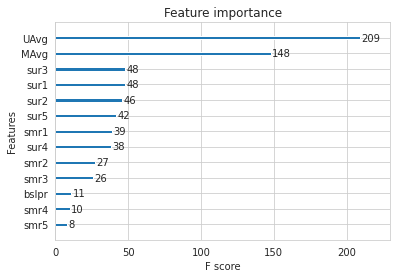

In [32]:
#Store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl']  = test_results
xgb.plot_importance(xgb_bsl)
plt.show()

###***Surprise KNNBaseline predictor***

- *__predicted Rating__* : (*__based on User-User similarity__* )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  *_Baseline prediction_ of (user,movie) rating*

- $ \pmb {N_i^k (u)}$ - *Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__*  

- _sim (u, v)_ - *__Similarity__ between users __u and v__*  
    - *Generally, it will be cosine similarity or Pearson correlation coefficient.* 
    - *But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity (we take base line predictions instead of mean rating of user/item)*

- *__Predicted rating__* : *__based on Item Item similarity__*
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  *__Notations follows same as above, user user based predicted rating__*

In [35]:
#Surprise KNNBaseline with user user similarities
from surprise import KNNBaseline
sim_options = {'user_based' : True,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2}
bsl_options = {'method': 'sgd'} 
knn_bsl_u   = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

Training the model now
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done in time taken    : 0:00:38.324086 

Evaluating the model with Train data.
time taken : 0:02:00.134287
TRAIN DATA RMSE :  0.33642097416508826
TRAIN DATA MAPE :  9.145093375416348
Adding train results in the dictionary.
Evaluating the model with Test data
time taken : 0:00:00.068436
TEST DATA RMSE :  1.0726493739667242
TEST DATA MAPE :  35.02094499698424
Adding the test results in test dictionary.
Total time taken to run this algorithm : 0:02:38.528535


In [36]:
#Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u']  = knn_bsl_u_test_results

In [37]:
#Surprise KNNBaseline with movie movie similarities
sim_options = {'user_based' : False,'name': 'pearson_baseline','shrinkage': 100,'min_support': 2} 
bsl_options = {'method': 'sgd'}
knn_bsl_m   = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

Training the model now
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done in time taken    : 0:00:01.550553 

Evaluating the model with Train data.
time taken : 0:00:10.032392
TRAIN DATA RMSE :  0.32584796251610554
TRAIN DATA MAPE :  8.447062581998374
Adding train results in the dictionary.
Evaluating the model with Test data
time taken : 0:00:00.067363
TEST DATA RMSE :  1.072758832653683
TEST DATA MAPE :  35.02269653015042
Adding the test results in test dictionary.
Total time taken to run this algorithm : 0:00:11.651620


In [38]:
#Storing these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m']  = knn_bsl_m_test_results

###***XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor***

*First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.*

 
*Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model.*

In [39]:
#add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']
reg_train.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.930020,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.177330,3.076302
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708,3.572503,3.401177
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411,3.255531,3.086772
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637,3.299517,3.249660
5,125275,33,3.581679,3.0,4.0,2.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,3.412698,4.092437,4,3.208080,2.382573,2.577606


In [40]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']
reg_test_df.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679,3.581679,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679,3.581679,3.581679
5,117617,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679


In [41]:
# prepare the train and test data
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']
x_test  = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test  = reg_test_df['rating']

In [42]:
#declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

Training the model.
[04:33:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training : Done In time :
Evaluating the model with TRAIN data.
Evaluating the model with Test data.
TEST DATA RMSE :  1.0767793575625662
TEST DATA MAPE :  34.44745951378593


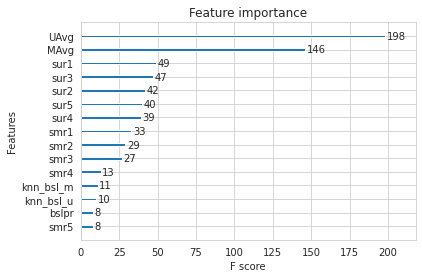

In [43]:
#store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl']  = test_results
xgb.plot_importance(xgb_knn_bsl)
plt.show()

###***SVD Matrix Factorization User Movie intractions***

- *__Predicted Rating :__*
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - *Representation of item(movie) in latent factor space*
        
        - $\pmb p_u$ - *Representation of user in new latent factor space*


- __Optimization problem with user item interactions and regularization to avoid overfitting__
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [45]:
#initiallize the model
from surprise import SVD
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

Training the model now
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done in time taken    : 0:00:08.535056 

Evaluating the model with Train data.
time taken : 0:00:01.555037
TRAIN DATA RMSE :  0.6574721240954099
TRAIN DATA MAPE :  19.704901088660474
Adding train results in the dictionary.
Evaluating the model with Test data
time taken : 0:00:00.061287
TEST DATA RMSE :  1.0726046873826458
TEST DATA MAPE :  35.01953535988152
Adding the test results in test dictionary.
Total time taken to run this algorithm : 0:00:10.153837


In [46]:
# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

###***SVD Matrix Factorization with implicit feedback from user : user rated movies***

- *__Predicted Rating :__* 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

- $ \pmb{I_u}$ --- *the set of all items rated by user u*

- $\pmb{y_j}$ --- *Our new set of item factors that capture implicit ratings.* 



- *__Optimization problem with user item interactions and regularization to avoid overfitting__*
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [47]:
#initiallize the model
from surprise import SVDpp
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

Training the model now
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done in time taken    : 0:02:09.565379 

Evaluating the model with Train data.
time taken : 0:00:06.985042
TRAIN DATA RMSE :  0.6032438403305899
TRAIN DATA MAPE :  17.49285063490268
Adding train results in the dictionary.
Evaluating the model with Test data
time taken : 0:00:00.068519
TEST DATA RMSE :  1.0728491944183447
TEST DATA MAPE :  35.03817913919887
Adding the test results in test dictionary.
Total time taken to run this algorithm : 0:02:16.619666


In [48]:
#Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp']  = svdpp_test_results

###***XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques***

In [50]:
#add the predicted values from both knns to this dataframe
reg_train['svd']   = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']
reg_train.head(6)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.930020,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.177330,3.076302,3.278967,3.538247
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708,3.572503,3.401177,3.385723,2.879361
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411,3.255531,3.086772,2.944656,3.091422
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637,3.299517,3.249660,3.456119,3.394619
5,125275,33,3.581679,3.0,4.0,2.0,4.0,5.0,3.0,2.0,3.0,2.0,3.0,3.412698,4.092437,4,3.208080,2.382573,2.577606,2.559047,2.632061


In [51]:
reg_test_df['svd']   = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']
reg_test_df.head(6) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679,3.581679,3.581679,3.581679,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679,3.581679,3.581679,3.581679,3.581679
5,117617,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


In [52]:
# prepare x and y for train and test data
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

In [53]:
xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

Training the model.
[05:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training : Done In time :
Evaluating the model with TRAIN data.
Evaluating the model with Test data.
TEST DATA RMSE :  1.0769599573828592
TEST DATA MAPE :  34.431788329400995


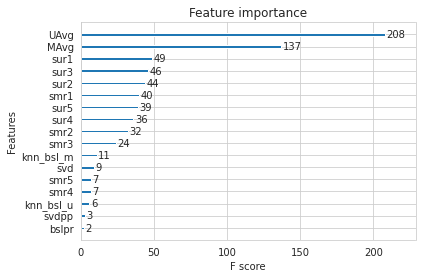

In [54]:
#store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results
xgb.plot_importance(xgb_final)
plt.show()

###***XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques***

In [55]:
# prepare train and test data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']
x_test  = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test  = reg_test_df['rating']

In [56]:
xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

Training the model.
[05:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training : Done In time :
Evaluating the model with TRAIN data.
Evaluating the model with Test data.
TEST DATA RMSE :  1.0753047860953797
TEST DATA MAPE :  35.07058962951319


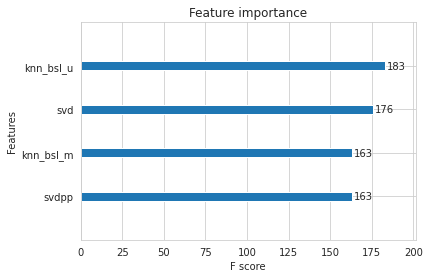

In [57]:
#store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models']  = test_results
xgb.plot_importance(xgb_all_models)
plt.show()

##***Comparision between all models***

In [58]:
#Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('sample/small/small_sample_results.csv')
models = pd.read_csv('sample/small/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_all_models    1.0753047860953797
first_algo         1.076373581778953
xgb_bsl           1.0765603714651855
xgb_knn_bsl       1.0767793575625662
xgb_final         1.0769599573828592
Name: rmse, dtype: object